In [55]:
!pip install pymongo
!pip install python-dotenv
!pip install pymongo[srv]
!pip install dnspython


In [79]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import os
import time
from dotenv import load_dotenv
import tensorflow
from bson.binary import Binary
from bson import ObjectId
import pymongo, gridfs
from pymongo import MongoClient
from gridfs import GridFS


In [80]:
#Busca as variáveis de ambiente

load_dotenv()

True

In [4]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  96.4M      0  0:00:08  0:00:08 --:--:-- 94.5M


In [5]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [6]:
!ls PetImages

Cat  Dog


In [7]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [81]:
image_size = (48, 48)
batch_size = 24

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1875 files belonging to 2 classes.
Using 1500 files for training.
Found 1875 files belonging to 2 classes.
Using 375 files for validation.


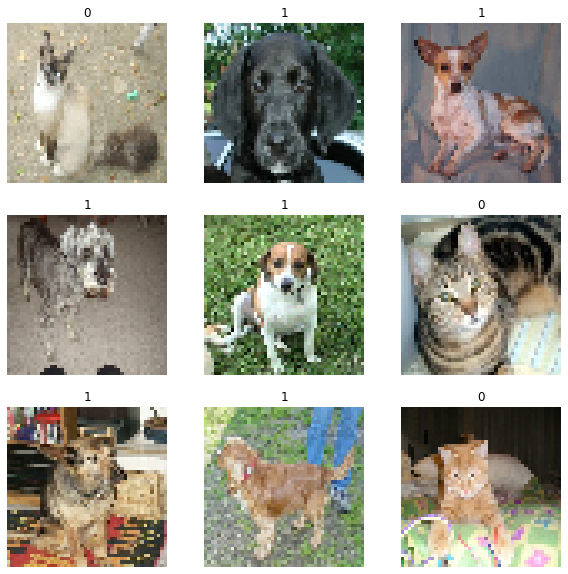

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [59]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

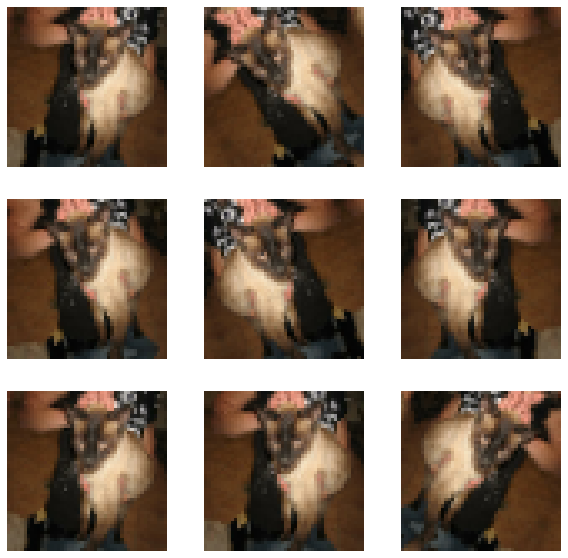

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [60]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [61]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [62]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


In [63]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [37]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/10
781/781 [==============================] - 35s 41ms/step - loss: 0.6141 - accuracy: 0.6716 - val_loss: 0.5419 - val_accuracy: 0.7270
Epoch 2/10
781/781 [==============================] - 31s 40ms/step - loss: 0.5154 - accuracy: 0.7521 - val_loss: 0.5040 - val_accuracy: 0.7463
Epoch 3/10
781/781 [==============================] - 30s 38ms/step - loss: 0.4700 - accuracy: 0.7798 - val_loss: 0.5164 - val_accuracy: 0.7542
Epoch 4/10
781/781 [==============================] - 30s 38ms/step - loss: 0.4381 - accuracy: 0.7973 - val_loss: 1.1096 - val_accuracy: 0.5790
Epoch 5/10
781/781 [==============================] - 30s 38ms/step - loss: 0.4114 - accuracy: 0.8144 - val_loss: 0.4405 - val_accuracy: 0.7832
Epoch 6/10
781/781 [==============================] - 31s 39ms/step - loss: 0.3890 - accuracy: 0.8276 - val_loss: 0.4559 - val_accuracy: 0.7704
Epoch 7/10
781/781 [==============================] - 30s 38ms/step - loss: 0.3713 - accuracy: 0.8358 - val_loss: 0.3571 - val_accuracy:

In [65]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/31.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 1s 1s/step
This image is 49.99 percent cat and 50.01 percent dog.


In [88]:
#Salva o modelo no formato h5 
model.save('model.h5') 

In [82]:
db = os.getenv('DB')
client = os.getenv('CLIENT_DEVELOP')
#client = os.getenv('CLIENT_PRODUCT')
collection = os.getenv('COLLECTION')
model_name = os.getenv('MODEL_NAME_B')

In [98]:

def save_model_to_mongo(model, model_name, client, db, collection):

    cluster = pymongo.MongoClient(client)
    db = cluster["compass"]
    collection = db["sprint3"]

    file_data = open(model_name, 'rb')
    data = file_data.read()

    fs = gridfs.GridFS(db)
    fs.put(data, filename=model_name)

    return 'success'


In [112]:
save_model_to_mongo(client=client,collection=collection,db=db,model=model,model_name='model.h5')

'success'

In [108]:
def load_saved_model_from_mongo(filename, client, db, collection):
    
    cluster = pymongo.MongoClient(client)
    db = cluster["compass"]
    collection = db["sprint3"]

    resp = db.fs.files.find_one({'filename':filename})
    model_atlas = fs.get(resp['_id']).read()
    output = open('model-test.h5','wb')
    output.write(model_atlas)
    output.close()
    return 

In [109]:
model_from_mongo = load_saved_model_from_mongo(filename='model.h5', client=client, db=db, collection=collection)

In [110]:
new_model = tf.keras.models.load_model('model-test.h5')

In [111]:
img = keras.preprocessing.image.load_img(
    "PetImages/Dog/31.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = new_model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 366ms/step
This image is 25.24 percent cat and 74.76 percent dog.
